## Libraries

In [1]:
import pandas as pd
import numpy as np
import re

!pip install demoji
import demoji
demoji.download_codes()

!pip install greek-stemmer-pos
from greek_stemmer import stemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import  cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.9 MB/s eta 0:00:00


/tmp/ipykernel_19/116043029.py:7: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


  Obtaining dependency information for pytest-cov from https://files.pythonhosted.org/packages/a7/4b/8b78d126e275efa2379b1c2e09dc52cf70df16fc3b90613ef82531499d73/pytest_cov-4.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for coverage[toml]>=5.2.1 from https://files.pythonhosted.org/packages/7d/c1/46a0a53b0dfa4c389c81290e3be9e5205d45003863565aa83d264cae4463/coverage-7.3.2-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 6.1 MB/s eta 0:00:00


## Read Files & Extract Information

In [2]:
# paths
TrainSet_File = '/kaggle/input/ys19-2023-assignment-1/train_set.csv'
ValidSet_File = '/kaggle/input/ys19-2023-assignment-1/valid_set.csv'
TestSet_File = '/kaggle/input/ys19-2023-assignment-1/test_set.csv'
GreekStopWords_File = '/kaggle/input/greekstopwords/stopwords-el.csv'

# read files (train, validation and test set) and save them in dataframes
dataframe_TrainSet = pd.read_csv(TrainSet_File, sep=',')
dataframe_ValidSet = pd.read_csv(ValidSet_File, sep=',')
dataframe_TestSet = pd.read_csv(TestSet_File, sep=',')

# read GreekStopWords_File and save this in dataframe
dataframe_GreekStopWords = pd.read_csv(GreekStopWords_File, sep=' ')
GreekStopWordsList =  list(dataframe_GreekStopWords["string"])
#GreekStopWordsList

$ $

$ \bullet $  $ $ $ $ Training Set

In [3]:
dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


$ $

$ \bullet $  $ $ $ $ Validation Set

In [4]:
dataframe_ValidSet.head()

,New_ID,Text,Sentiment,Party
0,435,@GLinard @teza_tereza @AdonisGeorgiadi @atsipr...,POSITIVE,SYRIZA
1,3061,Τσίπρας: Ζητήσαμε και από την αντιπολίτευση να...,NEGATIVE,SYRIZA
2,2161,"Ο σωστος ο Ελληνας, ο δημοκρατης, ο Ελληνας το...",NEGATIVE,ND
3,1271,@30__kai Ναι βλέπεις αυτά ενδιαφέρουν τους Μητ...,POSITIVE,ND
4,4396,Η συνέντευξη Μητσοτάκη στον Alpha: Υπό αίρεση ...,NEUTRAL,ND


$ $

$ \bullet $  $ $ $ $ Test Set

In [5]:
dataframe_TestSet.head()

,New_ID,Text,Party
0,1,Ο Κυριάκος Μητσοτάκης δεν ξέρει που είναι το Μ...,ND
1,2,Συνέντευξη της υποψήφιας βουλευτή με τη Νέα Δη...,ND
2,3,Σε αυτές τις εκλογές οι μαθητές και οι φοιτητέ...,KKE
3,4,Γεννηματά: Το ΚΙΝΑΛ δεν θα γίνει δεκανίκι κανε...,PASOK
4,5,"Την Κυριακή των εκλογών, Οκτώβρης 1993, ξημερώ...",ND


## Data processing and Analysis

####  Pre-processing

##### **1**. $ $  **Data Cleaning**

$ \bullet$ $ $ Auxiliary functions for Data Cleaning

In [6]:
# 1. Remove URLs
def remove_URLS(ww):
    w1 = ""

    word_list = ww.split()
    for word in word_list:
        if len(word) > 8:
            auxilary_str = word[:8]
            if auxilary_str == "https://":
                continue

        w1 += word
        w1 += " "

    return w1


# 2. Remove Hashtags
def remove_Hashtags(ww):
    w1 = ""
    
    word_list = ww.split()
    for word in word_list:
        auxilary_str = word[:1]
        if auxilary_str == "#":
            continue
        else:
            w1 += word
            w1 += " "

    return w1


# 3. Remove Tags
def remove_Tags(ww):
    w1 = ""

    word_list = ww.split()
    for word in word_list:
        auxilary_str = word[:1]
        if auxilary_str == "@":
            continue
        else:
            w1 += word
            w1 += " "

    return w1


# 4. Remove Symbols
def remove_symbols(ww):

    w1 = ""

    for c in ww:

        if c in ['+', '-', ':', '(', ')', '[', ']', '{', '}', '!',
                 '?', '$', '%', '^', '&', '*', '~', '\;', '«', '»',
                 '.', '`', '=', '#', '@', ']', '|', '‘', '、', ',',
                 '。', '”', '\'', '"']:
            w1 += ' '
        elif c == '_':
            w1 += ' '
        else:
            w1 += c

    return w1


# 5. Remove Emojis
def remove_emoji(ww):
    emoji_list = demoji.findall(ww)
    for emoji in emoji_list:
        ww = re.sub(emoji, ' ', ww)

    return ww

# 6. Remove Numbers
def remove_numbers(string):
    string = re.sub(r"\d+",' ' , string)
    return string


$\bullet $  $  $  Data Cleaning

In [7]:
def data_cleaning(text):

    text = remove_URLS(text)
    text = remove_Hashtags(text)
    text = remove_Tags(text)
    text = remove_symbols(text)
    text = remove_emoji(text)
    text = remove_numbers(text)
    
    return text

dataframe_TrainSet['Text'] = dataframe_TrainSet.apply(lambda row: data_cleaning(row['Text']), axis=1)
dataframe_ValidSet['Text'] = dataframe_ValidSet.apply(lambda row: data_cleaning(row['Text']), axis=1)
dataframe_TestSet['Text'] = dataframe_TestSet.apply(lambda row: data_cleaning(row['Text']), axis=1)

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,Κυριακη Κοριοί απολύμανση Καταπολέμηση κοριώ...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία καίνε τη...,NEGATIVE,ND
2,14146,Ισχυρό ΚΚΕ δύναμη του λαού στη Βουλή και στου...,POSITIVE,KKE
3,28716,Μνημονιακότατο το,NEUTRAL,KKE
4,32886,Αυτό που είναι συγκλονιστικό είναι η ψυχασθένε...,NEUTRAL,SYRIZA


##### **2**. $ $ **Simplification**

In [8]:
# convert all the letters to lowercase
def lowercase(string):
    string2 = string.lower()
    return string2

dataframe_TrainSet['Text'] = dataframe_TrainSet.apply(lambda row: lowercase(row['Text']), axis=1)
dataframe_ValidSet['Text'] = dataframe_ValidSet.apply(lambda row: lowercase(row['Text']), axis=1)
dataframe_TestSet['Text'] = dataframe_TestSet.apply(lambda row: lowercase(row['Text']), axis=1)

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,κυριακη κοριοί απολύμανση καταπολέμηση κοριώ...,NEUTRAL,SYRIZA
1,9531,έξι νέες επιστολές για τη μακεδονία καίνε τη...,NEGATIVE,ND
2,14146,ισχυρό κκε δύναμη του λαού στη βουλή και στου...,POSITIVE,KKE
3,28716,μνημονιακότατο το,NEUTRAL,KKE
4,32886,αυτό που είναι συγκλονιστικό είναι η ψυχασθένε...,NEUTRAL,SYRIZA


$ $

##### **3**. $ $ **StopWords**

In [9]:
# remove stop words
dataframe_TrainSet['Text'] = dataframe_TrainSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))
dataframe_ValidSet['Text'] = dataframe_ValidSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))
dataframe_TestSet['Text'] = dataframe_TestSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (GreekStopWordsList)]))

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,κυριακη κοριοί απολύμανση καταπολέμηση κοριών ...,NEUTRAL,SYRIZA
1,9531,έξι νέες επιστολές μακεδονία καίνε νδ μητσοτάκ...,NEGATIVE,ND
2,14146,ισχυρό κκε δύναμη λαού βουλή καθημερινούς αγώνες,POSITIVE,KKE
3,28716,μνημονιακότατο,NEUTRAL,KKE
4,32886,αυτό είναι συγκλονιστικό είναι ψυχασθένεια τσίπρα,NEUTRAL,SYRIZA


$ $

##### **4**. $ $ **Stemming**

In [10]:
# conversion of words into a common root
def Stemmer(ww):
    w1 = ""
    count = 0
    
    word_list = ww.split()
    for word in word_list:
        
        w1 += stemmer.stem_word(word, 'VBG')
        if (len(word_list) - 1) != count:
            w1 += " "
        
        count = count + 1
    
    return w1

dataframe_TrainSet['Text'] = dataframe_TrainSet.apply(lambda row: Stemmer(row['Text']), axis=1)
dataframe_ValidSet['Text'] = dataframe_ValidSet.apply(lambda row: Stemmer(row['Text']), axis=1)
dataframe_TestSet['Text'] = dataframe_TestSet.apply(lambda row: Stemmer(row['Text']), axis=1)

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,ΚΥΡΙΑΚ ΚΟΡΙ ΑΠΟΛΥΜΑΝΣ ΚΑΤΑΠΟΛΕΜΗΣ ΚΟΡΙ ΑΠΕΝΤΟΜ...,NEUTRAL,SYRIZA
1,9531,ΕΞΙ ΝΕ ΕΠΙΣΤΟΛ ΜΑΚΕΔΟΝΙ ΚΑΙΝ ΝΔ ΜΗΤΣΟΤΑΚ ΓΝΩΡΙ...,NEGATIVE,ND
2,14146,ΙΣΧΥΡ ΚΚΕ ΔΥΝΑΜ ΛΑ ΒΟΥΛ ΚΑΘΗΜΕΡΙΝ ΑΓΩΝ,POSITIVE,KKE
3,28716,ΜΝΗΜΟΝΙΑΚ,NEUTRAL,KKE
4,32886,ΑΥΤ ΕΙΝΑ ΣΥΓΚΛΟΝΙΣΤΙΚ ΕΙΝΑ ΨΥΧΑΣΘΕΝΕΙ ΤΣΙΠΡ,NEUTRAL,SYRIZA


$ $

##### **5**. $ $ **Delete the words with latin characters**

In [11]:
dataframe_TrainSet['Text'] = dataframe_TrainSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.islower() == False]))
dataframe_ValidSet['Text'] = dataframe_ValidSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.islower() == False]))
dataframe_TestSet['Text'] = dataframe_TestSet['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.islower() == False]))

dataframe_TrainSet.head()

,New_ID,Text,Sentiment,Party
0,35027,ΚΥΡΙΑΚ ΚΟΡΙ ΑΠΟΛΥΜΑΝΣ ΚΑΤΑΠΟΛΕΜΗΣ ΚΟΡΙ ΑΠΕΝΤΟΜ...,NEUTRAL,SYRIZA
1,9531,ΕΞΙ ΝΕ ΕΠΙΣΤΟΛ ΜΑΚΕΔΟΝΙ ΚΑΙΝ ΝΔ ΜΗΤΣΟΤΑΚ ΓΝΩΡΙ...,NEGATIVE,ND
2,14146,ΙΣΧΥΡ ΚΚΕ ΔΥΝΑΜ ΛΑ ΒΟΥΛ ΚΑΘΗΜΕΡΙΝ ΑΓΩΝ,POSITIVE,KKE
3,28716,ΜΝΗΜΟΝΙΑΚ,NEUTRAL,KKE
4,32886,ΑΥΤ ΕΙΝΑ ΣΥΓΚΛΟΝΙΣΤΙΚ ΕΙΝΑ ΨΥΧΑΣΘΕΝΕΙ ΤΣΙΠΡ,NEUTRAL,SYRIZA


#### Analysis

In [12]:
# merge the train, valid and test set into a dataframe
dataframe = pd.concat([dataframe_TrainSet, dataframe_ValidSet, dataframe_TestSet])

$\bullet$ $ $  Word Cloud

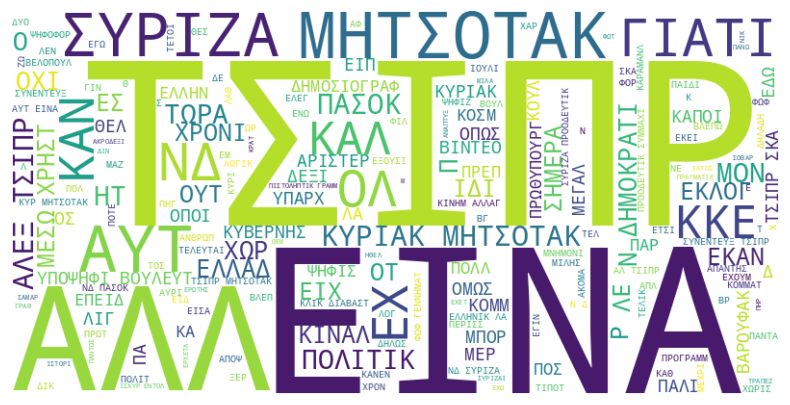

In [13]:
def Word_Cloud(data):
   
    words_list = []
    
    # divide each line into words and store them in a list
    for text in data:
        words = text.split()
        words_list.extend(words)
    
    # connect the words in a text with each other
    String_allWords = ' '.join(words_list)
    
    # create WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(String_allWords)
    
    # visualization
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
        

Word_Cloud(dataframe['Text'])

$\bullet$ $ $ Find the occurrences of each word

In [14]:
# Calculate the occurrences of each word.
bow_vectorizer = CountVectorizer()
bow_xtrain = bow_vectorizer.fit_transform(dataframe_TrainSet['Text'])
b = bow_xtrain.toarray()
k = np.sum(b, axis=0)  

feature_genres = bow_vectorizer.get_feature_names_out()

# Create a dictionary with the name of the genres and the number of their occurrences.
genre_appear = dict(zip(feature_genres, k))

# Sort the dictionary in descending order based on the number of appearances of the species.
sortedDict = dict(sorted(genre_appear.items(), key=lambda item: item[1]))
sortDescOrder = dict(reversed(list(sortedDict.items())))
sortDescOrder

{'τσιπρ': 8631,
 'μητσοτακ': 7886,
 'εινα': 6669,
 'νδ': 5541,
 'συριζα': 4890,
 'αυτ': 4138,
 'αλλ': 3113,
 'εχ': 3100,
 'κκε': 2689,
 'ολ': 2423,
 'κυριακ': 2283,
 'πασοκ': 2055,
 'γιατι': 2015,
 'καν': 1965,
 'κιναλ': 1734,
 'καλ': 1727,
 'πολιτικ': 1629,
 'εκλογ': 1608,
 'αλεξ': 1535,
 'μον': 1518,
 'συνεντευξ': 1461,
 'κυβερνης': 1423,
 'χωρ': 1322,
 'ητ': 1312,
 'ελλαδ': 1266,
 'σκα': 1262,
 'λα': 1177,
 'μερ': 1173,
 'τωρα': 1153,
 'δημοκρατι': 1146,
 'μεγαλ': 1110,
 'ψηφις': 1104,
 'χρονι': 1080,
 'γεννηματ': 1070,
 'ψηφ': 1048,
 'λε': 1033,
 'οχι': 1018,
 'υποψηφι': 1000,
 'νε': 969,
 'εκαν': 956,
 'ειπ': 951,
 'ειχ': 947,
 'βουλευτ': 938,
 'θελ': 905,
 'ελλην': 892,
 'ιδι': 887,
 'μπορ': 858,
 'ελληνικ': 854,
 'φωφ': 848,
 'ος': 834,
 'οτ': 822,
 'μεσω': 815,
 'πολ': 809,
 'ουτ': 791,
 'υπαρχ': 784,
 'σημερα': 784,
 'πρωτ': 775,
 'πρωθυπουργ': 752,
 'βαρουφακ': 742,
 'χρηστ': 739,
 'ες': 734,
 'μνημονι': 730,
 'φορ': 709,
 'εδω': 700,
 'οπως': 699,
 'αριστερ': 698,
 'προεκλογ

$\bullet$ $ $ Find the occurrences of each sentiment **Train & Valid set**

In [15]:
# merge the train and valid set into a dataframe
dataframe = pd.concat([dataframe_TrainSet, dataframe_ValidSet])

In [16]:
bow_vectorizer = CountVectorizer(lowercase=False)
bow_xtrain = bow_vectorizer.fit_transform(dataframe['Sentiment'])
b = bow_xtrain.toarray()
k = np.sum(b, axis=0)


feature_genres = bow_vectorizer.get_feature_names_out()

# Create a dictionary with the name of the genres and the number of their occurrences.
genre_appear = dict(zip(feature_genres, k))

print(genre_appear)

{'NEGATIVE': 13954, 'NEUTRAL': 13954, 'POSITIVE': 13954}


## Model Creation

              precision    recall  f1-score   support

           0       0.38      0.40      0.39      1744
           1       0.39      0.38      0.39      1744
           2       0.40      0.38      0.39      1744

    accuracy                           0.39      5232
   macro avg       0.39      0.39      0.39      5232
weighted avg       0.39      0.39      0.39      5232



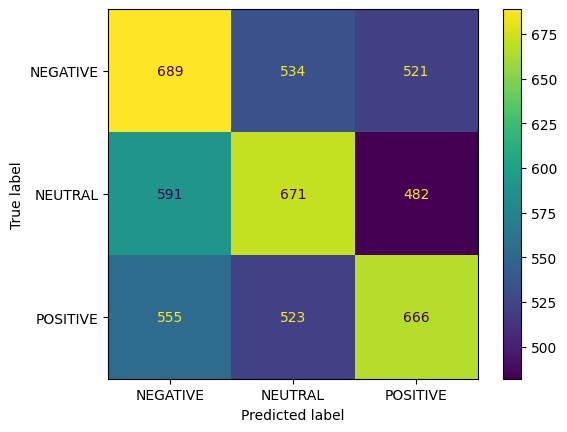

In [17]:
# convert labels to numerical values
labelencoder = LabelEncoder()  

# conversion of texts to numbers
bow_vectorizer = CountVectorizer()

# convert the measurements into integers
tfidf_transformer = TfidfTransformer()

Y_train = labelencoder.fit_transform(dataframe_TrainSet['Sentiment'])
X_train = (dataframe_TrainSet['Text'])

Y_val = labelencoder.fit_transform(dataframe_ValidSet['Sentiment'])
X_val = dataframe_ValidSet['Text']

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_bow)

X_val_bow = bow_vectorizer.transform(X_val)
X_val_tfidf = tfidf_transformer.transform(X_val_bow)

model = LogisticRegression().fit(X_train_tfidf, Y_train)

predicted = model.predict(X_val_tfidf)

print(classification_report(Y_val, predicted))

cm = metrics.confusion_matrix(Y_val, predicted)
labels = list(genre_appear.keys())
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()

## Experiments

$\bullet $  $  $  find the best ngram parameter for CountVectorizer

In [18]:
for ngram in [1,2]:

    bow_vectorizer = CountVectorizer(ngram_range=(1, ngram))

    Y_train = labelencoder.fit_transform(dataframe_TrainSet['Sentiment'])
    X_train = dataframe_TrainSet['Text']

    Y_val = labelencoder.fit_transform(dataframe_ValidSet['Sentiment'])
    X_val = dataframe_ValidSet['Text']
    
    X_test = dataframe_TestSet['Text']

    X_train_bow = bow_vectorizer.fit_transform(X_train)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_bow)

    X_val_bow = bow_vectorizer.transform(X_val)
    X_val_tfidf = tfidf_transformer.transform(X_val_bow)
    
    X_test_bow = bow_vectorizer.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_bow)

    LogReg = LogisticRegression().fit(X_train_tfidf, Y_train)

    LogReg_score = cross_val_score(LogReg, X_train_tfidf, Y_train, cv=5, scoring='accuracy')

    print(f"Accuracy: {LogReg_score}")
    print(f"\nAverage Accuracy: {LogReg_score.mean()*100:.2f} %")
    print(f"\nAverage std: {LogReg_score.std()*100:.2f} % \n")
    print(f"\n-----------------------------------\n")


Accuracy: [0.38110838 0.38301938 0.37865138 0.38288288 0.38315588]

Average Accuracy: 38.18 %

Average std: 0.17 % 


-----------------------------------

Accuracy: [0.38138138 0.3961234  0.38301938 0.39312039 0.38479388]

Average Accuracy: 38.77 %

Average std: 0.58 % 


-----------------------------------



In [19]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2))

Y_train = labelencoder.fit_transform(dataframe_TrainSet['Sentiment'])
X_train = (dataframe_TrainSet['Text'])

Y_val = labelencoder.fit_transform(dataframe_ValidSet['Sentiment'])
X_val = dataframe_ValidSet['Text']

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_bow)

X_val_bow = bow_vectorizer.transform(X_val)
X_val_tfidf = tfidf_transformer.transform(X_val_bow)

X_test_bow = bow_vectorizer.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_bow)

LogReg = LogisticRegression().fit(X_train_tfidf, Y_train)

LogReg_score = cross_val_score(LogReg, X_train_tfidf, Y_train, cv=5, scoring='accuracy')

print(f"Accuracy: {LogReg_score}")
print(f"\nAverage Accuracy: {LogReg_score.mean()*100:.2f} %")
print(f"\nAverage std: {LogReg_score.std()*100:.2f} % \n")
print(f"\n-----------------------------------\n")

Accuracy: [0.38138138 0.3961234  0.38301938 0.39312039 0.38479388]

Average Accuracy: 38.77 %

Average std: 0.58 % 


-----------------------------------



## Fine-tuning & Optimization

#### find the best parameters for LogisticRegression

In [20]:
tolerance = [0.1, 1e-3, 1e-5, 1e-7]
max_iter = [100, 500, 1000]
C = [0.1, 1, 10]
penalty = ["none", "l1", "l2"]
solver = ["saga", "sag", "liblinear", "lbfgs", "newton-cg"]
multi_class = ["auto", "ovr", "multinomial"]

**1.** $ $ find the best solver, penalty and multi_class 

In [21]:
for sol in solver: 
    for pen in penalty: 
        for mclass in multi_class:

            if sol == 'liblinear' and pen == 'l2' and mclass == 'multinomial': continue
            if sol != 'saga' and pen == 'l1' and mclass == 'multinomial': continue
            if sol != 'saga' and sol != 'liblinear' and pen == 'l1' and mclass == 'ovr': continue
            if sol == 'liblinear' and pen == 'none': continue
            if (sol != 'liblinear' and sol != 'saga') and pen == 'l1': continue 

            print('parameters:')
            print(f"penalty: {pen}, C: 1, solver: {sol}, multi_class: {mclass}, tol: 0.0001, n_jobs: -1,  max_iter: 100\n")
        
            LogReg = LogisticRegression(penalty = pen,
                                        C = 1,
                                        solver = sol,
                                        multi_class = mclass,
                                        tol = 0.0001,
                                        n_jobs = -1,
                                        max_iter = 100).fit(X_train_tfidf, Y_train)

            LogReg_score = cross_val_score(LogReg, X_train_tfidf, Y_train, cv=5, scoring='accuracy')

            print(f"Accuracy: {LogReg_score}")
            print(f"\nAverage Accuracy: {LogReg_score.mean()*100:.2f} %")
            print(f"\nAverage std: {LogReg_score.std()*100:.2f} % \n")
            print(f"\n-----------------------------------\n")


parameters:
penalty: none, C: 1, solver: saga, multi_class: auto, tol: 0.0001, n_jobs: -1,  max_iter: 100

Accuracy: [0.37564838 0.38220038 0.37906088 0.38097188 0.37319137]

Average Accuracy: 37.82 %

Average std: 0.33 % 


-----------------------------------

parameters:
penalty: none, C: 1, solver: saga, multi_class: ovr, tol: 0.0001, n_jobs: -1,  max_iter: 100

Accuracy: [0.37564838 0.38165438 0.38220038 0.38315588 0.37182637]

Average Accuracy: 37.89 %

Average std: 0.44 % 


-----------------------------------

parameters:
penalty: none, C: 1, solver: saga, multi_class: multinomial, tol: 0.0001, n_jobs: -1,  max_iter: 100

Accuracy: [0.37687688 0.38288288 0.38179088 0.37933388 0.37523888]

Average Accuracy: 37.92 %

Average std: 0.29 % 


-----------------------------------

parameters:
penalty: l1, C: 1, solver: saga, multi_class: auto, tol: 0.0001, n_jobs: -1,  max_iter: 100

Accuracy: [0.38738739 0.38506689 0.37510238 0.38875239 0.37947038]

Average Accuracy: 38.32 %

Average 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: [0.37209937 0.38165438 0.37878788 0.38684139 0.37237237]

Average Accuracy: 37.84 %

Average std: 0.56 % 


-----------------------------------

parameters:
penalty: none, C: 1, solver: lbfgs, multi_class: ovr, tol: 0.0001, n_jobs: -1,  max_iter: 100

Accuracy: [0.37441987 0.37824188 0.38547639 0.38397488 0.37537538]

Average Accuracy: 37.95 %

Average std: 0.45 % 


-----------------------------------

parameters:
penalty: none, C: 1, solver: lbfgs, multi_class: multinomial, tol: 0.0001, n_jobs: -1,  max_iter: 100



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: [0.37209937 0.38165438 0.37878788 0.38684139 0.37237237]

Average Accuracy: 37.84 %

Average std: 0.56 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: auto, tol: 0.0001, n_jobs: -1,  max_iter: 100



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: [0.38110838 0.3961234  0.38274638 0.39312039 0.38533989]

Average Accuracy: 38.77 %

Average std: 0.59 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: ovr, tol: 0.0001, n_jobs: -1,  max_iter: 100

Accuracy: [0.38547639 0.39475839 0.38452088 0.39298389 0.38970789]

Average Accuracy: 38.95 %

Average std: 0.40 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: multinomial, tol: 0.0001, n_jobs: -1,  max_iter: 100



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: [0.38110838 0.3961234  0.38274638 0.39312039 0.38533989]

Average Accuracy: 38.77 %

Average std: 0.59 % 


-----------------------------------

parameters:
penalty: none, C: 1, solver: newton-cg, multi_class: auto, tol: 0.0001, n_jobs: -1,  max_iter: 100



/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Accuracy: [0.37687688 0.37742288 0.38315588 0.38274638 0.36977887]

Average Accuracy: 37.80 %

Average std: 0.49 % 


-----------------------------------

parameters:
penalty: none, C: 1, solver: newton-cg, multi_class: ovr, tol: 0.0001, n_jobs: -1,  max_iter: 100



/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Accuracy: [0.37851488 0.37906088 0.38301938 0.38124488 0.36895987]

Average Accuracy: 37.82 %

Average std: 0.49 % 


-----------------------------------

parameters:
penalty: none, C: 1, solver: newton-cg, multi_class: multinomial, tol: 0.0001, n_jobs: -1,  max_iter: 100



/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Accuracy: [0.37687688 0.37742288 0.38315588 0.38274638 0.36977887]

Average Accuracy: 37.80 %

Average std: 0.49 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class: auto, tol: 0.0001, n_jobs: -1,  max_iter: 100



/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Accuracy: [0.38274638 0.3961234  0.38151788 0.39352989 0.38533989]

Average Accuracy: 38.79 %

Average std: 0.59 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class: ovr, tol: 0.0001, n_jobs: -1,  max_iter: 100

Accuracy: [0.38547639 0.39475839 0.38438438 0.39284739 0.38929839]

Average Accuracy: 38.94 %

Average std: 0.40 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class: multinomial, tol: 0.0001, n_jobs: -1,  max_iter: 100

Accuracy: [0.38274638 0.3961234  0.38151788 0.39352989 0.38533989]

Average Accuracy: 38.79 %

Average std: 0.59 % 


-----------------------------------



**2.** $ $  find the best C, tol and max_iter 

In [22]:
def selectCTolIter(parameters):
    
    pen = parameters[0]
    sol = parameters[1]
    mclass = parameters[2]
    
    for c in C:
        for tol in tolerance:
            for miter in max_iter: 
                print('parameters:')
                print(f"penalty: {pen}, C: {c}, solver: {sol}, multi_class: {mclass}, tol: {tol}, n_jobs: -1,  max_iter: {miter}\n")

                LogReg = LogisticRegression(penalty = pen,
                                            C = c,
                                            solver = sol,
                                            multi_class = mclass,
                                            tol = tol,
                                            n_jobs = -1,
                                            max_iter = miter).fit(X_train_tfidf,Y_train)

                LogReg_score = cross_val_score(LogReg, X_train_tfidf,Y_train, cv=5, scoring='accuracy')

                print(f"Accuracy: {LogReg_score}")
                print(f"\nAverage Accuracy: {LogReg_score.mean()*100:.2f} %")
                print(f"\nAverage std: {LogReg_score.std()*100:.2f} % \n")
                print(f"\n-----------------------------------\n")



selectCTolIter(['l2', 'saga', 'ovr'])
selectCTolIter(['l2', 'liblinear', 'ovr'])
selectCTolIter(['l2', 'lbfgs', 'ovr'])
selectCTolIter(['l2', 'newton-cg', 'ovr'])

parameters:
penalty: l2, C: 0.1, solver: saga, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 100

Accuracy: [0.38943489 0.38520339 0.39011739 0.39298389 0.39039039]

Average Accuracy: 38.96 %

Average std: 0.25 % 


-----------------------------------

parameters:
penalty: l2, C: 0.1, solver: saga, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 500

Accuracy: [0.38629539 0.38452088 0.39011739 0.39339339 0.38847939]

Average Accuracy: 38.86 %

Average std: 0.31 % 


-----------------------------------

parameters:
penalty: l2, C: 0.1, solver: saga, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 1000

Accuracy: [0.38888889 0.39134589 0.38984439 0.39298389 0.39093639]

Average Accuracy: 39.08 %

Average std: 0.14 % 


-----------------------------------

parameters:
penalty: l2, C: 0.1, solver: saga, multi_class: ovr, tol: 0.001, n_jobs: -1,  max_iter: 100

Accuracy: [0.38793339 0.39189189 0.39025389 0.39421239 0.38793339]

Average Accuracy: 39.04 %

Average std: 0.24 % 


--

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: [0.38520339 0.3951679  0.38479388 0.39284739 0.38970789]

Average Accuracy: 38.95 %

Average std: 0.41 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 500

Accuracy: [0.38520339 0.3951679  0.38479388 0.39284739 0.38970789]

Average Accuracy: 38.95 %

Average std: 0.41 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 1000

Accuracy: [0.38520339 0.3951679  0.38479388 0.39284739 0.38970789]

Average Accuracy: 38.95 %

Average std: 0.41 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: ovr, tol: 0.001, n_jobs: -1,  max_iter: 100



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: [0.38547639 0.39475839 0.38452088 0.39298389 0.38970789]

Average Accuracy: 38.95 %

Average std: 0.40 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: ovr, tol: 0.001, n_jobs: -1,  max_iter: 500

Accuracy: [0.38547639 0.39475839 0.38452088 0.39325689 0.38970789]

Average Accuracy: 38.95 %

Average std: 0.41 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: ovr, tol: 0.001, n_jobs: -1,  max_iter: 1000

Accuracy: [0.38547639 0.39475839 0.38452088 0.39325689 0.38970789]

Average Accuracy: 38.95 %

Average std: 0.41 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: ovr, tol: 1e-05, n_jobs: -1,  max_iter: 100

Accuracy: [0.38547639 0.39475839 0.38452088 0.39298389 0.38970789]

Average Accuracy: 38.95 %

Average std: 0.40 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: lbfgs, multi_class: ovr, tol

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Accuracy: [0.38806989 0.39189189 0.39025389 0.39421239 0.38793339]

Average Accuracy: 39.05 %

Average std: 0.24 % 


-----------------------------------

parameters:
penalty: l2, C: 0.1, solver: newton-cg, multi_class: ovr, tol: 1e-07, n_jobs: -1,  max_iter: 500



/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Accuracy: [0.38806989 0.39189189 0.39025389 0.39421239 0.38793339]

Average Accuracy: 39.05 %

Average std: 0.24 % 


-----------------------------------

parameters:
penalty: l2, C: 0.1, solver: newton-cg, multi_class: ovr, tol: 1e-07, n_jobs: -1,  max_iter: 1000



/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)


Accuracy: [0.38806989 0.39189189 0.39025389 0.39421239 0.38793339]

Average Accuracy: 39.05 %

Average std: 0.24 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 100

Accuracy: [0.38533989 0.39489489 0.38438438 0.39339339 0.38902539]

Average Accuracy: 38.94 %

Average std: 0.42 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 500

Accuracy: [0.38533989 0.39489489 0.38438438 0.39339339 0.38902539]

Average Accuracy: 38.94 %

Average std: 0.42 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 1000

Accuracy: [0.38533989 0.39489489 0.38438438 0.39339339 0.38902539]

Average Accuracy: 38.94 %

Average std: 0.42 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Accuracy: [0.38547639 0.39475839 0.38438438 0.39284739 0.38929839]

Average Accuracy: 38.94 %

Average std: 0.40 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class: ovr, tol: 1e-07, n_jobs: -1,  max_iter: 500



/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)


Accuracy: [0.38547639 0.39475839 0.38438438 0.39284739 0.38929839]

Average Accuracy: 38.94 %

Average std: 0.40 % 


-----------------------------------

parameters:
penalty: l2, C: 1, solver: newton-cg, multi_class: ovr, tol: 1e-07, n_jobs: -1,  max_iter: 1000

Accuracy: [0.38547639 0.39475839 0.38438438 0.39284739 0.38929839]

Average Accuracy: 38.94 %

Average std: 0.40 % 


-----------------------------------

parameters:
penalty: l2, C: 10, solver: newton-cg, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 100

Accuracy: [0.37837838 0.38875239 0.38288288 0.38998089 0.38151788]

Average Accuracy: 38.43 %

Average std: 0.44 % 


-----------------------------------

parameters:
penalty: l2, C: 10, solver: newton-cg, multi_class: ovr, tol: 0.1, n_jobs: -1,  max_iter: 500

Accuracy: [0.37837838 0.38875239 0.38288288 0.38998089 0.38151788]

Average Accuracy: 38.43 %

Average std: 0.44 % 


-----------------------------------

parameters:
penalty: l2, C: 10, solver: newton-cg, multi_

**Run a model with the best parameters**

              precision    recall  f1-score   support

           0       0.39      0.52      0.44      1744
           1       0.41      0.32      0.36      1744
           2       0.42      0.38      0.40      1744

    accuracy                           0.41      5232
   macro avg       0.41      0.41      0.40      5232
weighted avg       0.41      0.41      0.40      5232



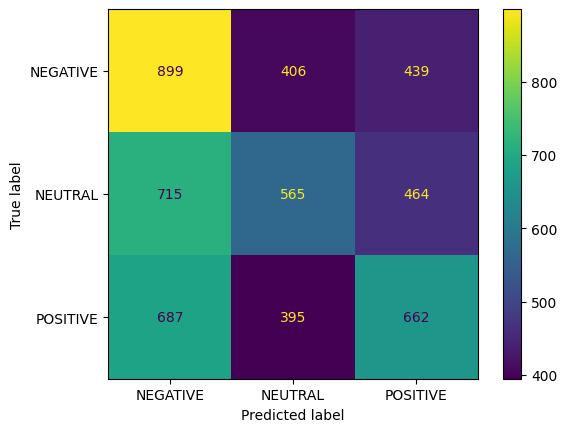

In [23]:
LogReg = LogisticRegression(penalty = 'l2',
                            C = 0.1,
                            solver = 'liblinear',
                            multi_class = 'ovr',
                            tol = 0.001,
                            n_jobs = -1,
                            max_iter = 100).fit(X_train_tfidf, Y_train)

predicted = LogReg.predict(X_val_tfidf)

print(classification_report(Y_val, predicted))

cm = metrics.confusion_matrix(Y_val, predicted)
labels = list(genre_appear.keys())
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()

Learning-curves

F1 Score Train: 0.2450980392156863
F1 Score Validation: 0.16666666666666666
F1 Score Train: 0.8883901382149108
F1 Score Validation: 0.3640230015732106
F1 Score Train: 0.8398688516770273
F1 Score Validation: 0.3808956106101864
F1 Score Train: 0.7350137044589604
F1 Score Validation: 0.3819088073253743
F1 Score Train: 0.7250822665669938
F1 Score Validation: 0.40554778612610143
F1 Score Train: 0.6981042703989305
F1 Score Validation: 0.4048108647919051
F1 Score Train: 0.6706047105186703
F1 Score Validation: 0.40325382193996745
F1 Score Train: 0.6418702734576133
F1 Score Validation: 0.3987253601560566
F1 Score Train: 0.6359930698395609
F1 Score Validation: 0.39339165352707367
F1 Score Train: 0.625438263970441
F1 Score Validation: 0.4057600145522774


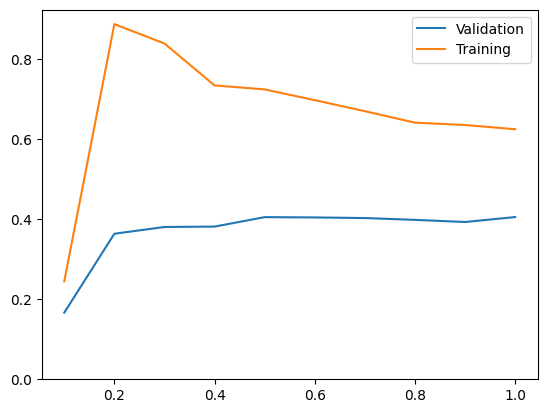

In [24]:
import matplotlib.pyplot as plt

list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  # training
  #
    X, X_unused, y, y_unused = train_test_split(X_train_tfidf, Y_train, test_size=1 - (times * 0.1 + 0.001))

    classifier = LogisticRegression(penalty = 'l2',
                                    C = 0.1,
                                    solver = 'liblinear',
                                    multi_class = 'ovr',
                                    tol = 0.001,
                                    n_jobs = -1,
                                    max_iter = 100)
    
    classifier.fit(X, np.ravel(y))

    results_train = classifier.predict(X)

    # validation
    #
    results = classifier.predict(X_val_tfidf)

    # score
    #
    f1_train = f1_score(y, results_train, average="weighted")
    print("F1 Score Train: " + str(f1_train))

    f1 = f1_score(Y_val, results, average="weighted")
    print("F1 Score Validation: " + str(f1))

    list_f1.append(f1)
    list_f1_train.append(f1_train)
    list_sample_size.append((times * 0.1 + 0.1))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

ROC curves

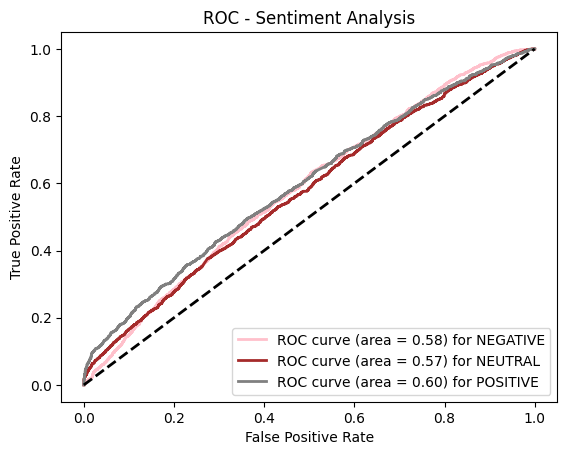

In [25]:
predicted_prob = LogReg.predict_proba(X_val_tfidf)

# calculation of ROC curve for each emotion category
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_val, predicted_prob[:, i], pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# visualization of ROC curve
plt.figure()
colors = ['pink', 'brown', 'grey']
labels = list(genre_appear.keys())

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]}')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Sentiment Analysis')
plt.legend(loc="lower right")
plt.show()

#### Test Set

In [26]:
LogReg = LogisticRegression(penalty = 'l2',
                            C = 0.1,
                            solver = 'liblinear',
                            multi_class = 'ovr',
                            tol = 0.001,
                            n_jobs = -1,
                            max_iter = 100).fit(X_train_tfidf, Y_train)

predicted = LogReg.predict(X_test_tfidf)

df_subm = dataframe_TestSet[['New_ID']].copy()
df_subm['Predicted'] = predicted
df_subm['Predicted'] = df_subm['Predicted'].replace({0: labels[0], 1: labels[1], 2: labels[2]})

df_subm = df_subm.rename(columns={"New_ID": "Id", "Predicted": "Predicted"})

df_subm = df_subm.set_index('Id')

df_subm.to_csv('/kaggle/working/submission.csv')

df_subm

,Predicted
Id,
1,POSITIVE
2,POSITIVE
3,POSITIVE
4,NEGATIVE
5,NEUTRAL
...,...
10466,NEGATIVE
10467,NEUTRAL
10468,NEGATIVE
